In [732]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, cumulative_trapezoid
from scipy.interpolate import interp1d

In [733]:
# Constants
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-2
c = 3.0e8  # Speed of light, m/s
M_sun = 1.989e30  # Solar mass, kg
AU = 1.496e11  # Astronomical unit, meters
kpc = 3.086e19  # Kiloparsec, meters
rho_cr = 9.47e-27 #kg/m^3
delta = 100 #overdensity parameter
rho_MC = rho_cr * delta

# Parameters
M = 1e-9 * M_sun  # Mass of minicluster, kg
v_t = 200 * 1000  # Tangential velocity, m/s
b = 1.6 * AU * 1e-3  # Impact parameter, meters
D_S = 778 * kpc  # Distance to source (Andromeda), meters
D_L = D_S / 2  # Distance to lens, meters
D_LS = D_S - D_L  # Distance between lens and source, meters

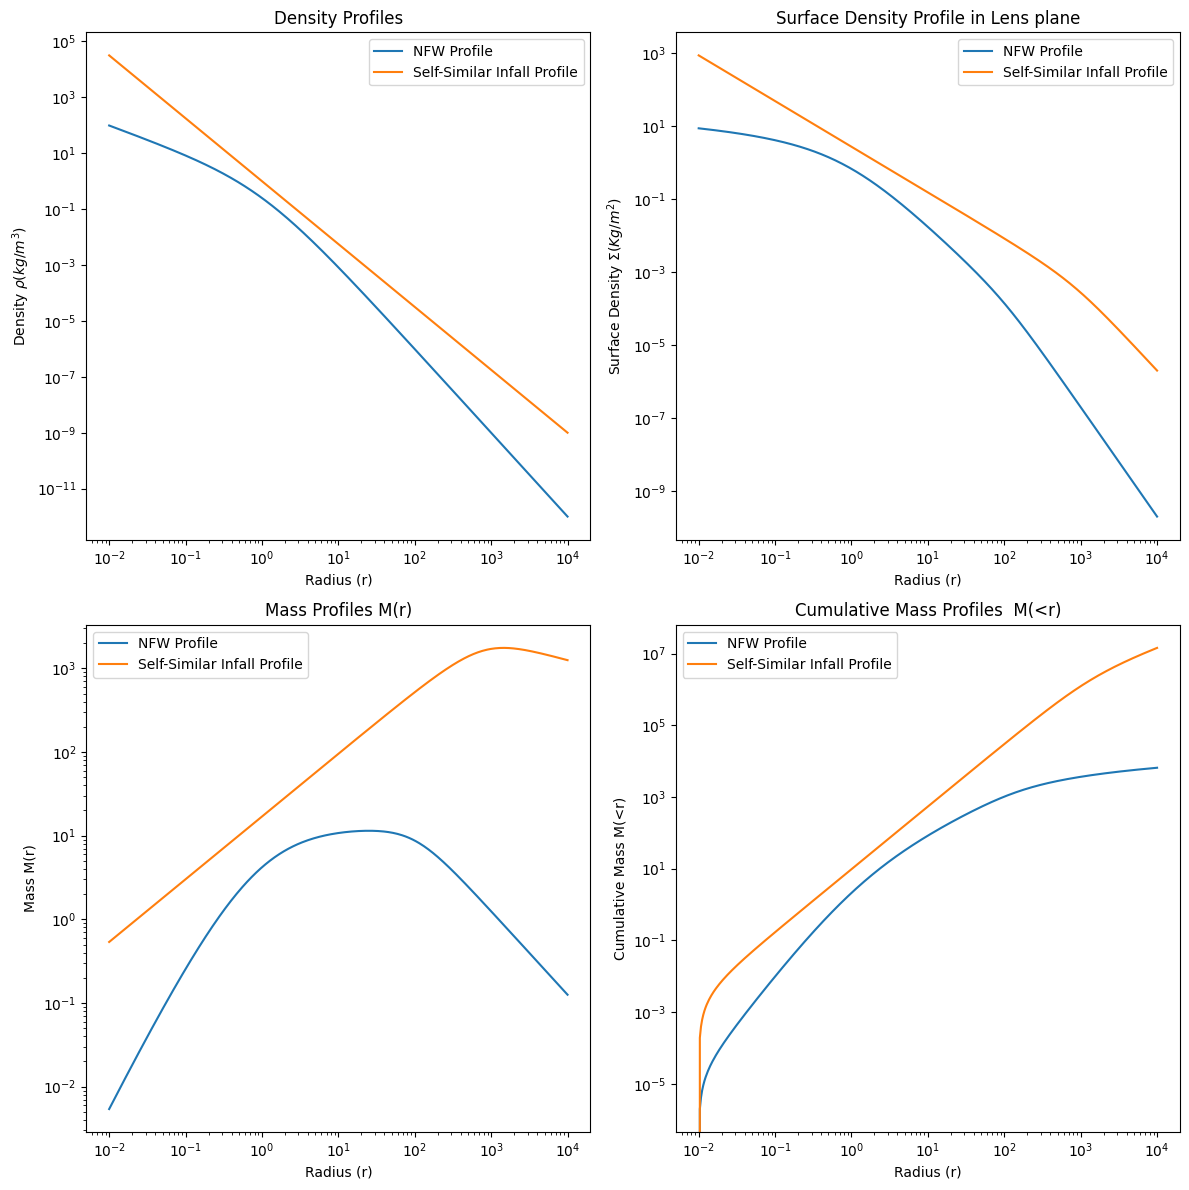

In [734]:
# Define density profiles
def nfw_density(r, rho_s = rho_s_NFW, r_s = r_s_NFW):
    return rho_s / ((r / r_s) * (1 + r / r_s)**2)

def ss_density(r, rho_s, r_s):
    # rho_s_r_s = rho_MC/4 * r_max**(9/4)
    return rho_s*(r_s/ r)**(9/4)


def surface_density(r, profile_func, rho_s, r_s):
   
    def integrand(x):
        return profile_func(np.sqrt(r**2 + x**2), rho_s, r_s)
    
    # Integrate along the line of sight within the radius limits
    if profile_func == nfw_density:
        r_max = 100 *r_s
        # print(f"r_max for nfw: {r_max}")
        result, _ = quad(integrand, 0, r_max)
    
    elif profile_func == ss_density:
        r_max = (3 * M / (4 * np.pi * rho_MC))**(1/4)
        # print(f"r_max for ssi: {r_max}")
        result, _ = quad(integrand, 0, 1000)
    
    return 2*result

rho_s_NFW = 1
r_s_NFW = 1

rho_s_SS = 1
r_s_SS = 1

r = np.logspace(-2, 4, 400)  # Radius array

# Calculate density profiles
density_nfw = nfw_density(r, rho_s_NFW, r_s_NFW)
density_ssi = ss_density(r, r_s_SS, rho_s_SS)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(r, density_nfw, label='NFW Profile')
plt.plot(r, density_ssi, label='Self-Similar Infall Profile')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel(r'Density $\rho (kg/m^3)$')
plt.legend()
plt.title('Density Profiles')

# Calculate and plot surface density profiles
surface_density_nfw = np.array([surface_density(x, nfw_density, rho_s_NFW, r_s_NFW) for x in r])
surface_density_ssi = np.array([surface_density(x, ss_density, rho_s_SS, r_s_SS) for x in r])

# Interpolation
surface_profile_nfw = interp1d(r, surface_density_nfw, kind='cubic', fill_value='extrapolate')
surface_profile_ssi = interp1d(r, surface_density_ssi, kind='cubic', fill_value='extrapolate')
# Define a fine grid for interpolation
r_fine = r #np.logspace(-2, 5, 1000)
surface_density_nfw_fine = surface_profile_nfw(r_fine)
surface_density_ssi_fine = surface_profile_ssi(r_fine)

# print(surface_profile_nfw(1), surface_profile_ssi(1))

plt.subplot(2, 2, 2)
plt.plot(r, surface_density_nfw, label='NFW Profile')
plt.plot(r, surface_density_ssi, label='Self-Similar Infall Profile')
# plt.plot(r_fine, surface_density_nfw_fine,'--', label='NFW Profile (Interpolated)')
# plt.plot(r_fine, surface_density_ssi_fine,'--', label='Self-Similar Infall Profile (Interpolated)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel(r'Surface Density $\Sigma (Kg/m^2)$')
plt.legend()
plt.title('Surface Density Profile in Lens plane')

mass_nfw_r = 2 * np.pi * r_fine**2 * surface_density_nfw_fine
mass_ssi_r = 2 * np.pi * r_fine**2 * surface_density_ssi_fine
# Calculate cumulative mass M(<r) by integrating M(r)
cumulative_mass_nfw = cumulative_trapezoid(mass_nfw_r, r_fine, initial=0)
cumulative_mass_ssi = cumulative_trapezoid(mass_ssi_r, r_fine, initial=0)


plt.subplot(2, 2, 3)
plt.plot(r_fine, mass_nfw_r, label='NFW Profile')
plt.plot(r_fine, mass_ssi_r, label='Self-Similar Infall Profile')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel('Mass M(r)')
plt.legend()
plt.title('Mass Profiles M(r)')

plt.subplot(2,2,4)
plt.plot(r_fine, cumulative_mass_nfw, label='NFW Profile')
plt.plot(r_fine, cumulative_mass_ssi, label='Self-Similar Infall Profile')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel('Cumulative Mass M(<r)')
plt.legend()
plt.title('Cumulative Mass Profiles  M(<r)')


plt.tight_layout()
plt.show()

In [735]:
# Calculate rho_s and r_s for NFW
r_max_NFW = (25*M /(np.pi*rho_MC*0.0003625))**(1/3)

rho_s_NFW = rho_MC  # Scale density for NFW profile
r_s_NFW = r_max_NFW/100

print(f"R_max_NFW: {r_max_NFW}  # Cumulative mass 0 to R_max by NFW profile gives M")
print(f"rho_s: {rho_s_NFW}")
print(f"r_s: {r_s_NFW}")


# Calculate r_max for SSi
r_max_ss = (3 * M / (4 * np.pi * rho_MC))**(1/4)
rho_s_r_s = rho_MC/4 * r_max_ss**(9/4)

print(f"\nR_max_SSI: {r_max_ss}  # Cumulative mass 0 to R_max by SSI profile gives M")
print(fr"rho_s*r_s^(9/4): {rho_s_r_s} # value of rho(r) at r = 1")



R_max_NFW: 3.5858240558222296e+16  # Cumulative mass 0 to R_max by NFW profile gives M
rho_s: 9.469999999999999e-25
r_s: 358582405582222.94

R_max_SSI: 149640464872.09705  # Cumulative mass 0 to R_max by SSI profile gives M
rho_s*r_s^(9/4): 3.297238386475039 # value of rho(r) at r = 1


In [736]:
# Define density profiles

def nfw_density(r, rho_s = rho_s_NFW, r_s = r_s_NFW):
    return rho_s / ((r / r_s) * (1 + r / r_s)**2)

def ss_density(r, rho_s= 0, r_s = 0, product = rho_s_r_s):
    if rho_s == 0:
        return product / r**(9/4)
    else:
        return rho_s*(r_s/ r)**(9/4)

In [737]:
# Function to calculate the surface density by integrating along the line of sight
def surface_density(r, profile_func):
    # print(r)
   
    def integrand(x):
        # print(f"r: {r}, r^2: {r**2},  x^2 : {x**2}, r2+x2: {np.sqrt(r**2 + x**2)}")
        return profile_func(np.sqrt(r**2 + x**2))
    
    # Integrate along the line of sight within the radius limits
    if profile_func == nfw_density:
        r_max = r_max_NFW
        # print(f"r_max for nfw: {r_max}, {r}, {r_max**2 - r**2}, {np.sqrt(r_max**2 - r**2)}")

    elif profile_func == ss_density:
        r_max = r_max_ss
        # print(f"r_max for ssi: {r_max}, {r}, {r_max**2 - r**2}, {np.sqrt(r_max**2 - r**2)}")

    # Perform the integration
    result, _ = quad(integrand, 0, np.sqrt(r_max**2 - r**2))

    print(2*result)
    return 2*result

In [738]:
x_max = r_max_NFW*1e2
R = np.logspace(-2, np.log10(x_max), 400)  # Radius array
# print(R)

# Calculate density profiles
density_nfw = nfw_density(R)
density_ssi = ss_density(R)

# Calculate and plot surface density profiles
surface_density_nfw = np.array([surface_density(x, nfw_density) for x in R])#[R <= r_max_NFW]
surface_density_ssi = np.array([surface_density(x, ss_density) for x in R])#[R <= r_max_ss]])

# Interpolation
surface_profile_nfw = interp1d(R, surface_density_nfw, kind='cubic', fill_value='extrapolate')
surface_profile_ssi = interp1d(R, surface_density_ssi, kind='cubic', fill_value='extrapolate')


# Define a fine grid for interpolation
r_fine = R #np.logspace(-2, 5, 1000)
Sigma_nfw = surface_profile_nfw(r_fine)
Sigma_ssi = surface_profile_ssi(r_fine)

# print(surface_profile_nfw(1), surface_profile_ssi(1))

# Calculate cumulative mass M(<r) by integrating M(r)
mass_nfw_r = 2 * np.pi * r_fine* Sigma_nfw
mass_ssi_r = 2 * np.pi * r_fine* Sigma_ssi
cumulative_mass_nfw = cumulative_trapezoid(mass_nfw_r, r_fine, initial=0)
cumulative_mass_ssi = cumulative_trapezoid(mass_ssi_r, r_fine, initial=0)

# cumulative_mass_nfw = cumulative_trapezoid(4*np.pi*r_fine**2 *density_nfw, r_fine, initial=0)
# cumulative_mass_ssi = cumulative_trapezoid(4*np.pi*r_fine**2 *density_ssi, r_fine, initial=0)


1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.9018886340569746e-09
1.901888634

C:\Users\Akshank Tyagi\AppData\Local\Temp\ipykernel_21260\3075446251.py:19: RuntimeWarning: invalid value encountered in sqrt
  result, _ = quad(integrand, 0, np.sqrt(r_max**2 - r**2))


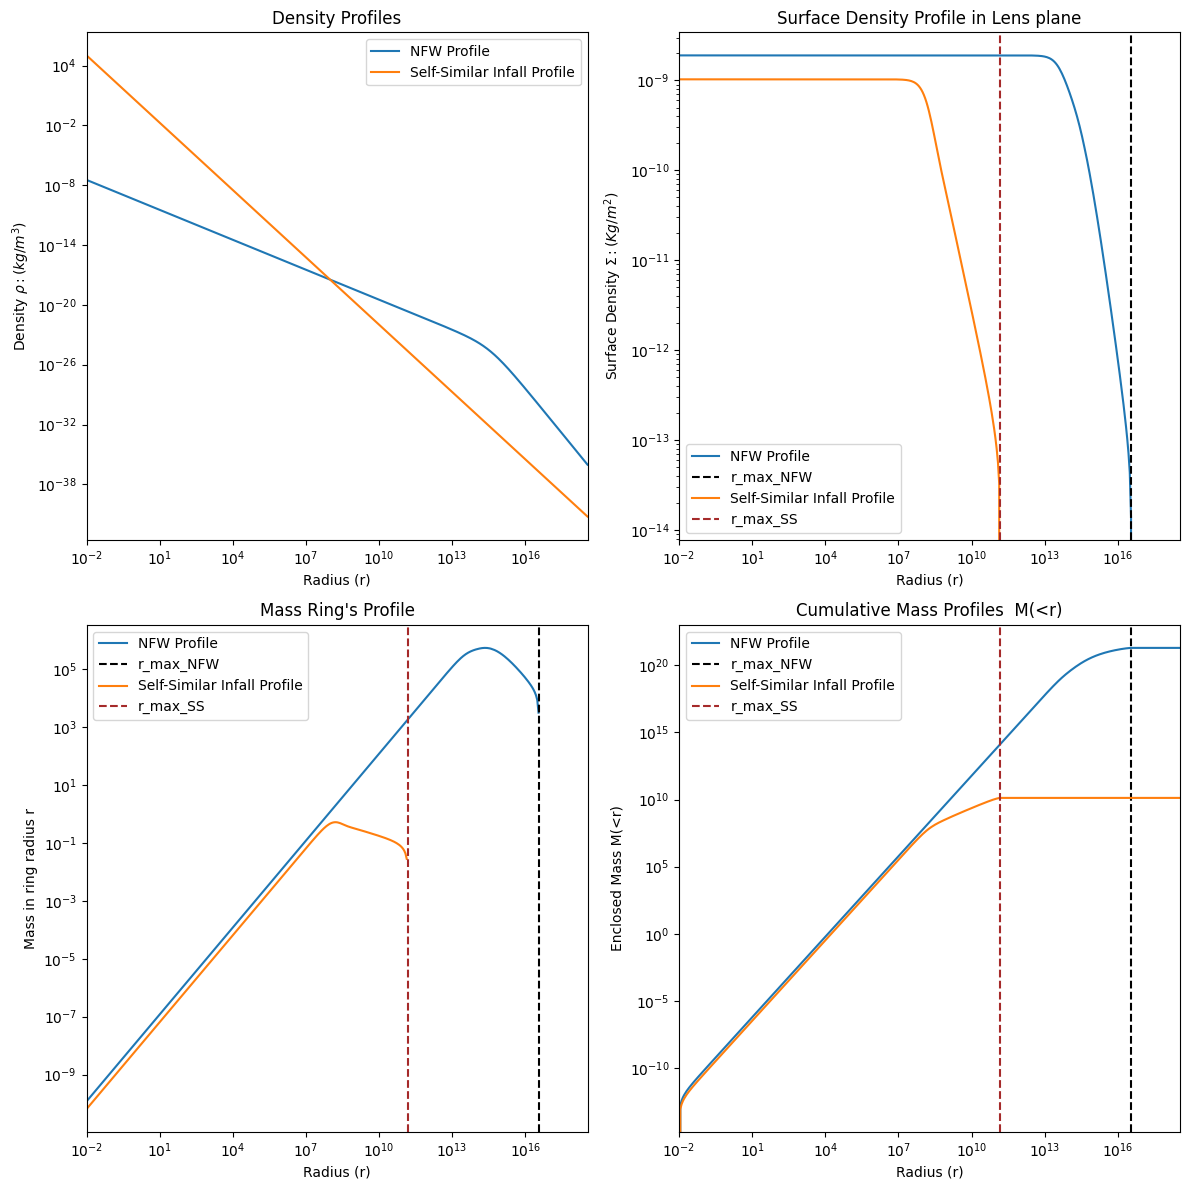

In [739]:

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(R, density_nfw, label='NFW Profile')
plt.plot(R, density_ssi, label='Self-Similar Infall Profile')
plt.xlim(1e-2, x_max)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel(r'Density $\rho : (kg/m^3)$')
plt.legend()
plt.title('Density Profiles')

plt.subplot(2, 2, 2)
plt.plot(R, surface_density_nfw, label='NFW Profile')
plt.axvline(x=r_max_NFW, color='black', linestyle='--', label='r_max_NFW')
plt.plot(R, surface_density_ssi, label='Self-Similar Infall Profile')
# plt.plot(r_fine, surface_density_nfw_fine,'--', label='NFW Profile (Interpolated)')
# plt.plot(r_fine, surface_density_ssi_fine,'--', label='Self-Similar Infall Profile (Interpolated)')
plt.axvline(x=r_max_ss, color='brown', linestyle='--', label='r_max_SS')
plt.xlim(1e-2, x_max)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel(r'Surface Density $\Sigma : (Kg/m^2)$')
plt.legend()
plt.title('Surface Density Profile in Lens plane')

plt.subplot(2, 2, 3)
plt.plot(r_fine[r_fine <= r_max_NFW] , mass_nfw_r[r_fine <= r_max_NFW] , label='NFW Profile') #[r_fine <= r_max_NFW] , *r_fine/2
plt.axvline(x=r_max_NFW, color='black', linestyle='--', label='r_max_NFW')
plt.plot(r_fine[r_fine <= r_max_ss] , mass_ssi_r[r_fine <= r_max_ss] , label='Self-Similar Infall Profile') #[r_fine <= r_max_ss] , *r_fine/2
plt.axvline(x=r_max_ss, color='brown', linestyle='--', label='r_max_SS')
plt.xlim(1e-2, x_max)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel('Mass in ring radius r')
plt.legend()
plt.title("Mass Ring's Profile")

plt.subplot(2,2,4)
plt.plot(r_fine, cumulative_mass_nfw, label='NFW Profile')
plt.axvline(x=r_max_NFW, color='black', linestyle='--', label='r_max_NFW')
plt.plot(r_fine, cumulative_mass_ssi, label='Self-Similar Infall Profile')
plt.axvline(x=r_max_ss, color='brown', linestyle='--', label='r_max_SS')
plt.xlim(1e-2, x_max)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (r)')
plt.ylabel('Enclosed Mass M(<r)')
plt.legend()
plt.title('Cumulative Mass Profiles  M(<r)')


plt.tight_layout()
plt.show()

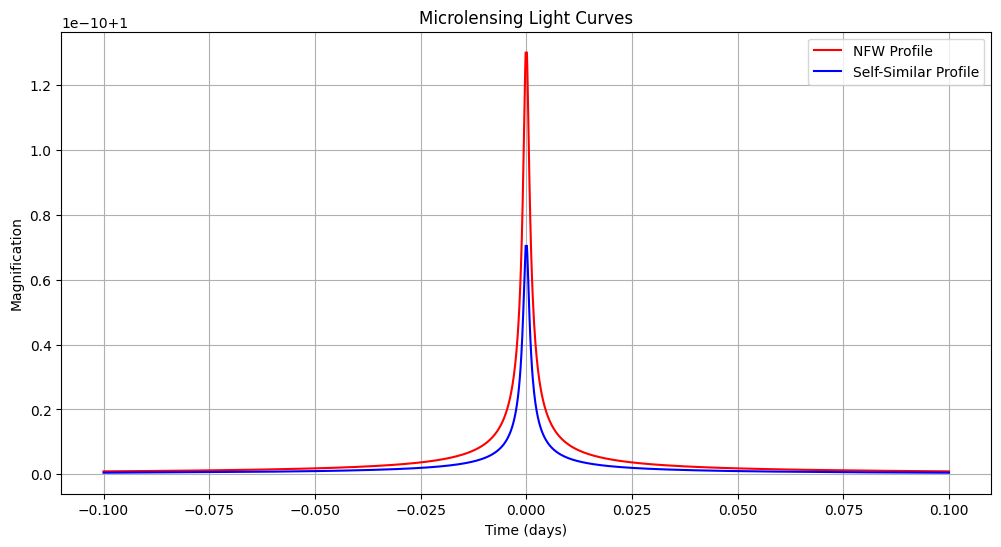

In [743]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
c = 3.0e8  # Speed of light in m/s

def magnification(r, surface_density_profile, D_L, D_S, D_LS):
    """Calculate the magnification based on the density profile."""
    Sigma_c = (c**2 * D_S) / (4 * np.pi * G * D_L * D_LS)
    
    # Mass enclosed
    # M_r = 2 * np.pi * r * surface_density_profile
    M_r = cumulative_trapezoid(2 * np.pi * r * surface_density_profile, r, initial=0)
    B = M_r / (Sigma_c * np.pi * r**2)
    C = np.gradient(M_r, r) / (Sigma_c * np.pi * r**2)

    # print (r, Sigma_c, M_r, B, C )

    return 1/((1 - B) * (1 + B - C))#, B, C

# Sample data
time = np.linspace(-0.1, 0.1, 2000)  # Time array in days
b = 1.6e-3  # Impact parameter in AU
v_t = 200 * 1e3 / 86400  # Tangential velocity in AU/day
r = np.sqrt(b**2 + (v_t * time)**2)  # Radial distance in AU

surface_density_nfw = surface_profile_nfw(r)
surface_density_ssi = surface_profile_ssi(r)


# Calculate magnifications
magnifications_NFW = magnification(r, surface_density_nfw , D_L, D_S, D_LS)
magnifications_SS = magnification(r, surface_density_ssi, D_L, D_S, D_LS)


# Plot light curves
plt.figure(figsize=(12, 6))
plt.plot(time, magnifications_NFW, 'r-', label='NFW Profile')
plt.plot(time, magnifications_SS, 'b-', label='Self-Similar Profile')
plt.xlabel('Time (days)')
plt.ylabel('Magnification')
plt.title('Microlensing Light Curves')
plt.legend()
plt.grid(True)
plt.show()
